In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

In [50]:
from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [6]:
BATCH_SIZE = 64
EPOCHS = 100
LATENT_DIM = 256
NUM_SAMPLES = 10000
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [86]:
try:
  import keras.backend as K
  if len(K.tensorflow_backend._get_available_gpus()) > 0:
    from keras.layers import CuDNNLSTM as LSTM
    from keras.layers import CuDNNGRU as GRU
except:
  pass

### Storing the Data

In [13]:
input_texts = []
target_texts = []
target_texts_inputs = []

In [14]:
t = 0
for line in open("spa.txt", encoding="utf-8"):
    t = t + 1
    if t > NUM_SAMPLES:
        break

    ## Ensure Input and Target Seperated By Tab
    if "\t" not in line:
        continue

    input_text = line.split("\t")[0]
    translation = line.split("\t")[1]
    
    target_text = translation + " <eos>"
    target_text_input = "<sos> " + translation ## Teacher Forcing

    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)

print("Num Samples:", len(input_texts))    

Num Samples: 10000


### Tokenize the ****INPUT**** Sentences

In [32]:
tokenizer_inputs = Tokenizer(num_words = MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

In [33]:
word2idx_inputs = tokenizer_inputs.word_index
print("Found %s unique input tokens." % len(word2idx_inputs))

Found 2254 unique input tokens.


In [41]:
max_len_input = max([len(s) for s in input_sequences])

### Tokenize the ****OUTPUT**** Sentences

In [45]:
tokenizer_outputs = Tokenizer(num_words = MAX_NUM_WORDS, filters = '')
tokenizer_outputs.fit_on_texts(target_texts + target_texts_inputs)
target_sequences = tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [46]:
word2idx_outputs = tokenizer_outputs.word_index
print("Found %s unique output tokens." % len(word2idx_outputs))

Found 6381 unique output tokens.


In [47]:
num_words_output = len(word2idx_outputs) + 1

In [48]:
max_len_target = max([len(s) for s in target_sequences])

### Pad the Sequences

In [51]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

encoder_inputs.shape: (10000, 5)
encoder_inputs[0]: [ 0  0  0  0 15]
decoder_inputs[0]: [   2 1453    0    0    0    0    0    0    0    0]
decoder_inputs.shape: (10000, 10)


### Store the Pre-Trained Word Vectors

In [59]:
# store all the pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open('glove.6B.100d.txt', encoding="utf-8") as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))

Loading word vectors...
Found 400000 word vectors.


In [61]:
len(word2vec['the'])

100

### Prepare Embedding Matrix

In [62]:
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)

In [64]:
embedding_matrix = np.zeros((num_words, 100))

In [67]:
for word, i in word2idx_inputs.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

### Create the Embedding Layer

In [68]:
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input,
  # trainable=True
)

### One Hot encoding for Target Feedback Loop

In [71]:
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    if word != 0:
      decoder_targets_one_hot[i, t, word] = 1

### Build the Model

##### Encoder

In [76]:
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = LSTM(
  LATENT_DIM,
  return_state=True
)

In [77]:
# keep only the states to pass into decoder

encoder_outputs, h, c = encoder(x)
encoder_states = [h, c]

##### Decoder

In [78]:
decoder_inputs_placeholder = Input(shape=(max_len_target,))
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

In [79]:
# Since the decoder is a "to-many" model we want to have return_sequences=True
decoder_lstm = LSTM(
  LATENT_DIM,
  return_sequences=True,
  return_state=True
)

In [80]:
decoder_outputs, _, _ = decoder_lstm(
  decoder_inputs_x,
  initial_state = encoder_states
)

In [81]:
# final dense layer for predictions
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [82]:
# Create the model object
model = Model([encoder_inputs_placeholder, decoder_inputs_placeholder], decoder_outputs)

In [83]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 10)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 5, 100)               225500    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 10, 100)              638200    ['input_2[0][0]']             
                                                                                              

In [87]:
def custom_loss(y_true, y_pred):
  # both are of shape N x T x K
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)


def acc(y_true, y_pred):
  # both are of shape N x T x K
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

  # 0 is padding, don't include those
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total

model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])

In [88]:
r = model.fit(
  [encoder_inputs, decoder_inputs], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
)

Epoch 1/100
125/125 [==============================] - 46s 330ms/step - loss: 5.9541 - acc: 0.2824 - val_loss: 5.6562 - val_acc: 0.2724
Epoch 2/100
125/125 [==============================] - 38s 307ms/step - loss: 4.9467 - acc: 0.3002 - val_loss: 5.4485 - val_acc: 0.2880
Epoch 3/100
125/125 [==============================] - 38s 305ms/step - loss: 4.6019 - acc: 0.3200 - val_loss: 5.3402 - val_acc: 0.3071
Epoch 4/100
125/125 [==============================] - 39s 310ms/step - loss: 4.2721 - acc: 0.3501 - val_loss: 5.1550 - val_acc: 0.3260
Epoch 5/100
125/125 [==============================] - 37s 295ms/step - loss: 3.9593 - acc: 0.3837 - val_loss: 5.0077 - val_acc: 0.3470
Epoch 6/100
125/125 [==============================] - 37s 299ms/step - loss: 3.6785 - acc: 0.4123 - val_loss: 4.9326 - val_acc: 0.3664
Epoch 7/100
125/125 [==============================] - 38s 302ms/step - loss: 3.4291 - acc: 0.4341 - val_loss: 4.8573 - val_acc: 0.3824
Epoch 8/100
125/125 [===========================

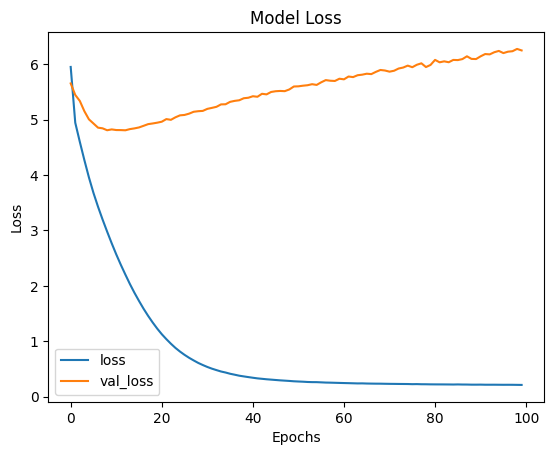

Accuracy metric not found. Check if it's added in the model compilation.


C:\Users\write\miniconda3\envs\tf_tr\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [90]:
# Plot loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Plot accuracy (check if the metric is recorded)
if 'accuracy' in r.history:
    plt.plot(r.history['accuracy'], label='accuracy')
    plt.plot(r.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
else:
    print("Accuracy metric not found. Check if it's added in the model compilation.")

# Save model
model.save('SEQ2SEQ.h5')

This code is building a sequence-to-sequence model, typically used in tasks like machine translation or text generation, by defining an encoder-decoder architecture. Here's a breakdown of what each part of the code is doing:

### 1. **Creating the Encoder Model**
   ```python
   encoder_model = Model(encoder_inputs_placeholder, encoder_states)
   ```
   - This creates a stand-alone encoder model that takes in `encoder_inputs_placeholder` (the input sequence) and outputs `encoder_states` (final hidden states).
   - These encoder states will be used as the initial states for the decoder, essentially "encoding" the input into a representation that the decoder can then use to generate output.

### 2. **Setting Up Decoder Initial States**
   ```python
   decoder_state_input_h = Input(shape=(LATENT_DIM,))
   decoder_state_input_c = Input(shape=(LATENT_DIM,))
   decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
   ```
   - `decoder_state_input_h` and `decoder_state_input_c` represent the previous hidden and cell states of the decoder, which are required as inputs to the LSTM in each decoding step.
   - `LATENT_DIM` refers to the dimensionality of the LSTM's hidden states.

### 3. **Single Word Input and Embedding for Decoder**
   ```python
   decoder_inputs_single = Input(shape=(1,))
   decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)
   ```
   - `decoder_inputs_single` takes a single word (time step of 1) as input, to allow for step-by-step predictions during inference.
   - `decoder_inputs_single_x` is the embedded representation of this single word.

### 4. **Building the Decoder LSTM Layer for Predictions**
   ```python
   decoder_outputs, h, c = decoder_lstm(
      decoder_inputs_single_x,
      initial_state=decoder_states_inputs
   )
   decoder_states = [h, c]
   decoder_outputs = decoder_dense(decoder_outputs)
   ```
   - `decoder_lstm` takes the embedded single-word input and previous decoder states to output the next predicted word (`decoder_outputs`) and the updated hidden (`h`) and cell (`c`) states.
   - `decoder_dense` is a dense layer that maps the decoder's LSTM output to the vocabulary size, producing a probability distribution over the next possible word.

### 5. **Creating the Decoder Model for Sampling**
   ```python
   decoder_model = Model(
      [decoder_inputs_single] + decoder_states_inputs, 
      [decoder_outputs] + decoder_states
   )
   ```
   - This `decoder_model` is the sampling model used during inference. It takes:
     - The previous word, `decoder_inputs_single`
     - The previous hidden and cell states, `decoder_states_inputs`
   - It outputs:
     - The predicted word `decoder_outputs`
     - The updated states `decoder_states`
   - This allows the model to generate one word at a time and propagate the states forward for each new prediction.

### 6. **Index to Word Mapping for Interpreting Output**
   ```python
   idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
   idx2word_trans = {v:k for k, v in word2idx_outputs.items()}
   ```
   - `idx2word_eng` and `idx2word_trans` map indices back to words for the input and output vocabularies, respectively.
   - These mappings are used to interpret the model's numeric outputs as human-readable words.

### Summary
Overall, this code sets up a sequence-to-sequence inference model by defining an encoder and a decoder. The encoder generates an initial state, which is passed to the decoder to predict one word at a time, using the previous word and state information at each step. The mappings at the end help translate the model’s numerical outputs into words.

In [91]:
encoder_model = Model(encoder_inputs_placeholder, encoder_states)

decoder_state_input_h = Input(shape=(LATENT_DIM,))
decoder_state_input_c = Input(shape=(LATENT_DIM,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoder_states_inputs = [decoder_state_input_h] # gru

decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# this time, we want to keep the states too, to be output
# by our sampling model
decoder_outputs, h, c = decoder_lstm(
  decoder_inputs_single_x,
  initial_state=decoder_states_inputs
)
# decoder_outputs, state_h = decoder_lstm(
#   decoder_inputs_single_x,
#   initial_state=decoder_states_inputs
# ) #gru
decoder_states = [h, c]
# decoder_states = [h] # gru
decoder_outputs = decoder_dense(decoder_outputs)

# The sampling model
# inputs: y(t-1), h(t-1), c(t-1)
# outputs: y(t), h(t), c(t)
decoder_model = Model(
  [decoder_inputs_single] + decoder_states_inputs, 
  [decoder_outputs] + decoder_states
)

# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

The `decode_sequence` function generates a translated sequence (e.g., in a machine translation task) or a sequential prediction using the encoder-decoder model. Here’s a step-by-step breakdown:

### 1. **Encoding the Input Sequence**
   ```python
   states_value = encoder_model.predict(input_seq)
   ```
   - This line uses the `encoder_model` to process `input_seq` (the input sentence) and output the initial hidden and cell states, `states_value`.
   - These states are used to initialize the decoder’s generation process.

### 2. **Initializing the Target Sequence**
   ```python
   target_seq = np.zeros((1, 1))
   target_seq[0, 0] = word2idx_outputs['<sos>']
   ```
   - `target_seq` is a sequence of length 1, which will hold the generated word at each step.
   - The sequence is initialized with the start-of-sequence token (`<sos>`) to begin the decoding.

### 3. **Defining the End-of-Sequence (EOS) Condition**
   ```python
   eos = word2idx_outputs['<eos>']
   ```
   - `eos` is the index for the end-of-sequence token (`<eos>`), which will signal the model to stop generating words once it’s reached.

### 4. **Decoding Loop**
   ```python
   output_sentence = []
   for _ in range(max_len_target):
   ```
   - The loop generates one word at a time, up to a maximum sequence length (`max_len_target`), or until the end-of-sequence token is predicted.

   Inside the loop:

   - **Predicting Next Word and States**:
     ```python
     output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
     ```
     - `decoder_model` takes `target_seq` (current word) and `states_value` (current states) and predicts the next word (`output_tokens`) and updates the states (`h` and `c`).
     - `output_tokens` is a probability distribution over the vocabulary for the next word.

   - **Selecting the Predicted Word**:
     ```python
     idx = np.argmax(output_tokens[0, 0, :])
     ```
     - The function selects the index of the highest-probability word from `output_tokens`.

   - **Checking End-of-Sequence**:
     ```python
     if eos == idx:
       break
     ```
     - If the predicted word is the end-of-sequence token (`eos`), the loop breaks, ending the generation.

   - **Appending the Word**:
     ```python
     word = ''
     if idx > 0:
       word = idx2word_trans[idx]
       output_sentence.append(word)
     ```
     - The predicted word’s index (`idx`) is mapped back to its actual word using `idx2word_trans` and added to `output_sentence`.

   - **Updating Target Sequence and States**:
     ```python
     target_seq[0, 0] = idx
     states_value = [h, c]
     ```
     - `target_seq` is updated to the current predicted word index (`idx`), which becomes the input for the next time step.
     - `states_value` is updated with the new hidden and cell states for the next prediction.

### 5. **Returning the Generated Sentence**
   ```python
   return ' '.join(output_sentence)
   ```
   - The function joins all words in `output_sentence` to form the final translated or generated sentence and returns it.

### Summary
This function uses the encoder-decoder model to iteratively predict each word in the output sequence, one at a time. It starts with an initial state from the encoder, takes the last generated word as input, and stops either when reaching the end-of-sequence token or when hitting the maximum sequence length.

In [92]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  states_value = encoder_model.predict(input_seq)
  target_seq = np.zeros((1, 1))
  target_seq[0, 0] = word2idx_outputs['<sos>']
  eos = word2idx_outputs['<eos>']
    
  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    output_tokens, h, c = decoder_model.predict(
      [target_seq] + states_value
    )
    idx = np.argmax(output_tokens[0, 0, :])
    # End sentence of EOS
    if eos == idx:
      break
    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

    # Update states
    states_value = [h, c]

  return ' '.join(output_sentence)

### Do some Translation

In [93]:
while True:
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input:', input_texts[i])
  print('Translation:', translation)

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

1/1 [==============================] - 0s 38ms/step
-
Input: She seems rich.
Translation: ella tiene rico.


Continue? [Y/n] n
